In [1]:
import os
import librosa
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder ,StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout ,  BatchNormalization, Input ,LSTM ,GRU 
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from tensorflow.keras.callbacks import EarlyStopping


In [2]:
def extract_features_balanced(file_path, max_len=173, n_mfcc=40, n_mels=128):
    try:
        y, sr = librosa.load(file_path, sr=None)

        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)

        mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels)
        log_mel_spec = librosa.power_to_db(mel_spec)

        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        zcr = librosa.feature.zero_crossing_rate(y)
        spec_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
        spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
        rms = librosa.feature.rms(y=y)

        def pad(x):
            return np.pad(x, ((0, 0), (0, max_len - x.shape[1])), mode='constant') if x.shape[1] < max_len else x[:, :max_len]

        combined = np.vstack([
            pad(mfcc), pad(delta), pad(delta2),
            pad(log_mel_spec), pad(chroma),
            pad(zcr), pad(spec_centroid),
            pad(spec_bw), pad(rms)
        ])

        # Normalize
        combined = (combined - np.mean(combined, axis=1, keepdims=True)) / (np.std(combined, axis=1, keepdims=True) + 1e-6)
        return combined

    except Exception as e:
        print(f"Error in {file_path}: {e}")
        return None



In [3]:
def get_emotion(filename):
    emotion_dict = {
        '01': 'neutral',
        '02': 'calm',
        '03': 'happy',
        '04': 'sad',
        '05': 'angry',
        '06': 'fearful',
        '07': 'disgust',
        '08': 'surprised'
    }
    
    try:
        emotion_code = filename.split("-")[2]
        return emotion_dict.get(emotion_code, "unknown")
    except:
        return "unknown"
data = []
labels = []
skipped_files = 0

folders = ["songs", "speech"]
base_dir = "audio/"  # or your actual path

for folder in folders:
    folder_path = os.path.join(base_dir, folder)
    for actor in os.listdir(folder_path):
        actor_path = os.path.join(folder_path, actor)
        if not os.path.isdir(actor_path):
            continue

        for file in tqdm(os.listdir(actor_path), desc=f"{folder}/{actor}"):
            if not file.endswith(".wav"):
                continue

            file_path = os.path.join(actor_path, file)
            emotion = get_emotion(file)
            features = extract_features_balanced(file_path, max_len=173)

            if features is not None and emotion != "unknown":
                data.append(features)
                labels.append(emotion)
            else:
                skipped_files += 1

print(f"✅ Loaded samples: {len(data)}")
print(f"🛑 Skipped files: {skipped_files}")


songs/Actor_17: 100%|███████████████████████████████████████████████████████████████████████████████| 44/44 [00:05<00:00,  8.78it/s]
songs/Actor_18: 0it [00:00, ?it/s]
speech/Actor_24: 100%|██████████████████████████████████████████████████████████████████████████████| 60/60 [00:08<00:00,  7.40it/s]

✅ Loaded samples: 2452
🛑 Skipped files: 0


In [4]:
X = np.array(data)
y = np.array(labels)


In [5]:
from sklearn.preprocessing import StandardScaler

# Step 1: Flatten features (to 2D) for scaling
X_reshaped = X.reshape(X.shape[0], -1)  # shape: (samples, features * time)

# Step 2: Apply standard scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped)

# Step 3: Reshape back to original shape
num_features, time_steps = data[0].shape
X = X_scaled.reshape(X.shape[0], num_features, time_steps)
# use your actual dimensions here


In [6]:
print("Total Samples:", X.shape[0])
print("Feature Shape per Sample:", X.shape[1:]) 
print("Unique Emotion Labels:", set(y))


Total Samples: 2452
Feature Shape per Sample: (264, 173)
Unique Emotion Labels: {np.str_('surprised'), np.str_('happy'), np.str_('angry'), np.str_('fearful'), np.str_('calm'), np.str_('sad'), np.str_('neutral'), np.str_('disgust')}


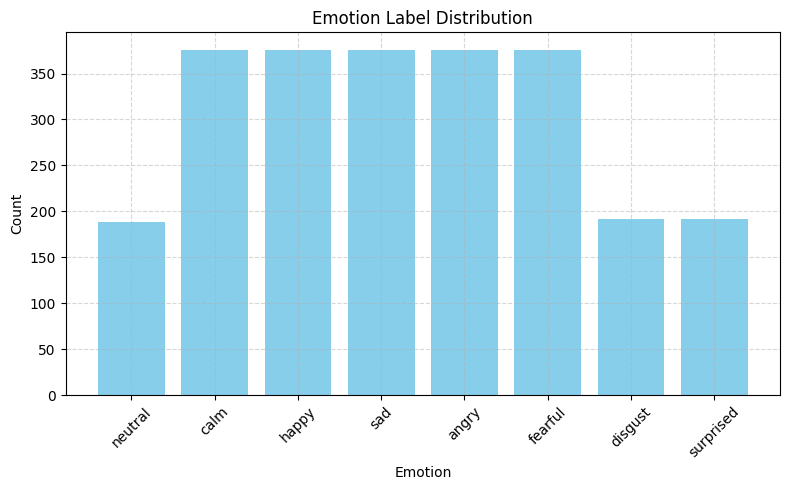

In [7]:
emotion_counts = Counter(y)

plt.figure(figsize=(8, 5))
plt.bar(emotion_counts.keys(), emotion_counts.values(), color='skyblue')
plt.title("Emotion Label Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

In [8]:
# Check if all samples have same shape
shapes = [x.shape for x in X]
unique_shapes = set(shapes)

if len(unique_shapes) == 1:
    print("✅ All samples have consistent shape:", unique_shapes.pop())
else:
    print("⚠️ Inconsistent sample shapes detected:", unique_shapes)


✅ All samples have consistent shape: (264, 173)


In [9]:
from sklearn.utils import shuffle

X_shuffled, y_shuffled = shuffle(X, y, random_state=42)


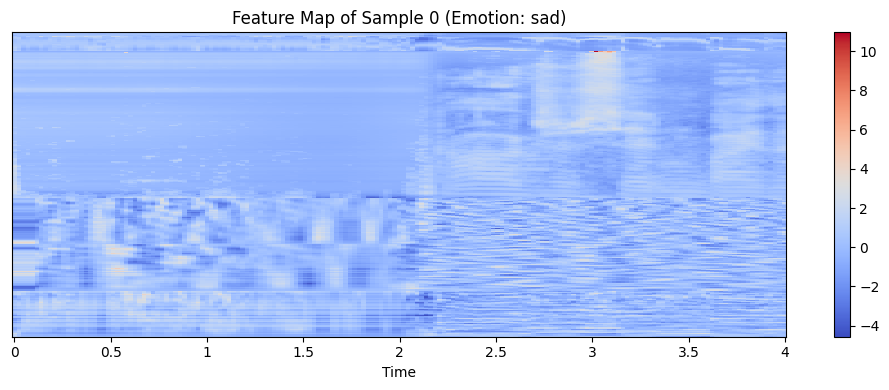

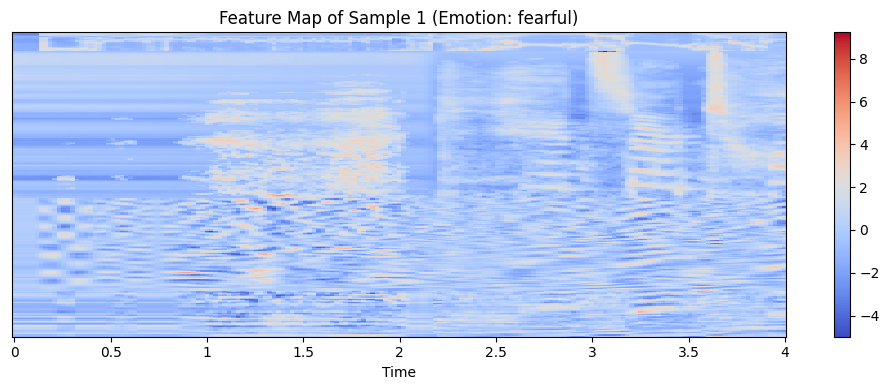

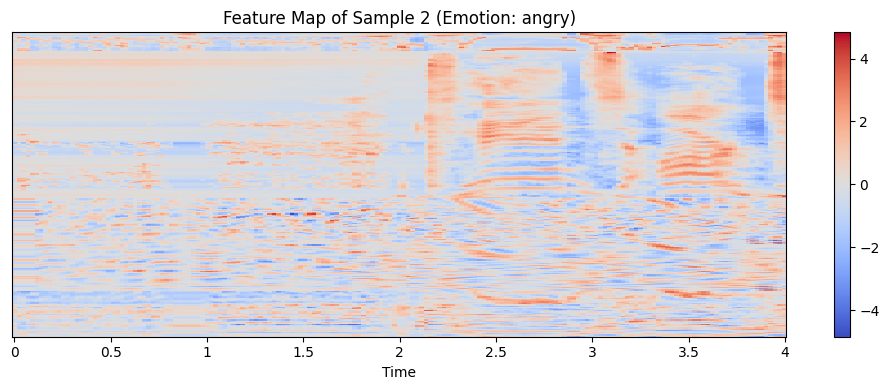

In [10]:
def plot_sample(index):
    sample = X_shuffled[index]
    label = y_shuffled[index]

    import matplotlib.pyplot as plt
    import librosa.display

    plt.figure(figsize=(10, 4))
    librosa.display.specshow(sample, x_axis='time')
    plt.colorbar()
    plt.title(f"Feature Map of Sample {index} (Emotion: {label})")
    plt.tight_layout()
    plt.show()

# Show diverse samples now
for i in range(3):
    plot_sample(i)


In [11]:
print("✅ No. of unique labels:", len(set(y_shuffled)))
print("✅ Feature array shape: ", X_shuffled.shape)
print("✅ Label array shape: ", y_shuffled.shape)
print("✅ Example emotion label:", y_shuffled[0])



✅ No. of unique labels: 8
✅ Feature array shape:  (2452, 264, 173)
✅ Label array shape:  (2452,)
✅ Example emotion label: sad


In [12]:
print(y_shuffled[:10])

['sad' 'fearful' 'angry' 'sad' 'happy' 'happy' 'calm' 'calm' 'sad'
 'fearful']


In [13]:
# Initialize encoder
encoder = LabelEncoder()

# Fit and transform labels
y_encoded = encoder.fit_transform(y_shuffled)

# Now y_encoded is a NumPy array of integers (0 to N-1)
print("🔢 Encoded Labels:", y_encoded[:10])
print("Encoded labels:", np.unique(y_encoded, return_counts=True))
print("🔁 Classes:", encoder.classes_)

🔢 Encoded Labels: [6 3 0 6 4 4 1 1 6 3]
Encoded labels: (array([0, 1, 2, 3, 4, 5, 6, 7]), array([376, 376, 192, 376, 376, 188, 376, 192]))
🔁 Classes: ['angry' 'calm' 'disgust' 'fearful' 'happy' 'neutral' 'sad' 'surprised']


In [14]:
import joblib
joblib.dump(encoder, 'label_encoder.pkl')


['label_encoder.pkl']

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_shuffled, y_encoded,
    test_size=0.2,      # 20% for testing
    random_state=42,    # for reproducibility
    stratify=y_encoded  # ensure class balance in split
)

# Confirm shapes
print("🧪 Training samples:", X_train.shape)
print("🧪 Testing samples :", X_test.shape)

🧪 Training samples: (1961, 264, 173)
🧪 Testing samples : (491, 264, 173)


In [16]:
print(X_train.shape)  # e.g., (num_samples, num_features, time_steps)


(1961, 264, 173)


X_train_cnn = X_train[..., np.newaxis]  # Shape: (samples, 264, 173, 1)
X_test_cnn = X_test[..., np.newaxis]


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

num_classes = len(np.unique(y_encoded))  # total emotions


model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(264, 173, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])


model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True
)
history = model.fit(
    X_train_cnn, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_test_cnn, y_test),
    callbacks=[early_stop],
    verbose=2
)


test_loss, test_acc = model.evaluate(X_test_cnn, y_test)
print("✅ Test Accuracy:", test_acc)


import collections
print(collections.Counter(y_train))

print("Unique classes in train:", set(y_train))
print("Unique classes in test:", set(y_test))


print(X_train.shape)           # should be (samples, 264, 173)
print(X_train_cnn.shape)       # should be (samples, 264, 173, 1)


In [17]:
print(set(labels))  # Should include multiple emotions, not just one or two


{'surprised', 'happy', 'angry', 'fearful', 'calm', 'sad', 'neutral', 'disgust'}


y_pred_probs = model.predict(X_test_cnn)
y_pred = np.argmax(y_pred_probs, axis=1)

# Overall Accuracy & F1
overall_acc = accuracy_score(y_test, y_pred)
overall_f1 = f1_score(y_test, y_pred, average='weighted')

# Report & Matrix
report = classification_report(y_test, y_pred, target_names=encoder.classes_, output_dict=True)
report_text = classification_report(y_test, y_pred, target_names=encoder.classes_)
cm = confusion_matrix(y_test, y_pred)

# 🎯 Class-wise accuracy
class_acc = {label: f"{100 * report[label]['recall']:.2f}%" for label in encoder.classes_}

# 🔲 Confusion Matrix Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# 📝 Print Results
print("✅ Overall Accuracy:", f"{overall_acc * 100:.2f}%")
print("✅ Weighted F1 Score:", f"{overall_f1 * 100:.2f}%")
print("✅ Class-wise Accuracy:")
for k, v in class_acc.items():
    print(f"   - {k}: {v}")

In [18]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)


In [19]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
# best model, determined by a grid search
model_params = {
    'alpha': 0.01,
    'batch_size': 256,
    'epsilon': 1e-08, 
    'hidden_layer_sizes': (300,), 
    'learning_rate': 'adaptive', 
    'max_iter': 500, 
}

mlp = MLPClassifier(**model_params)
mlp.fit(X_train_flat, y_train)

y_pred_mlp = mlp.predict(X_test_flat)

# Evaluation
print("✅ Accuracy:", accuracy_score(y_test, y_pred_mlp) * 100, "%")
print("✅ F1 Score:", f1_score(y_test, y_pred_mlp, average='weighted') * 100, "%")
print("✅ Classification Report:")
print(classification_report(y_test, y_pred_mlp, target_names=encoder.classes_))


✅ Accuracy: 50.91649694501018 %
✅ F1 Score: 50.386952227733886 %
✅ Classification Report:
              precision    recall  f1-score   support

       angry       0.52      0.72      0.61        75
        calm       0.44      0.56      0.49        75
     disgust       0.52      0.44      0.47        39
     fearful       0.52      0.53      0.53        75
       happy       0.55      0.51      0.53        75
     neutral       0.66      0.50      0.57        38
         sad       0.46      0.33      0.39        75
   surprised       0.50      0.38      0.43        39

    accuracy                           0.51       491
   macro avg       0.52      0.50      0.50       491
weighted avg       0.51      0.51      0.50       491



In [21]:
X_train_crnn = np.transpose(X_train, (0, 2, 1))  # (samples, time, features)
X_test_crnn = np.transpose(X_test, (0, 2, 1))    # same


In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GRU, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Input shape: (time_steps, feature_dims)
input_shape = (X_train_crnn.shape[1], X_train_crnn.shape[2])

model = Sequential([
    Conv1D(64, kernel_size=5, activation='relu', input_shape=input_shape),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    GRU(128, return_sequences=False),
    Dropout(0.3),

    Dense(128, activation='relu'),
    Dropout(0.3),

    Dense(len(np.unique(y_encoded)), activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train
history = model.fit(
    X_train_crnn, y_train,
    validation_data=(X_test_crnn, y_test),
    batch_size=32,
    epochs=40,
    callbacks=[early_stop],
    verbose=2
)


C:\Users\viren\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/40
62/62 - 7s - 114ms/step - accuracy: 0.2254 - loss: 2.0075 - val_accuracy: 0.2933 - val_loss: 1.8645
Epoch 2/40
62/62 - 2s - 35ms/step - accuracy: 0.3682 - loss: 1.6571 - val_accuracy: 0.3747 - val_loss: 1.7057
Epoch 3/40
62/62 - 2s - 35ms/step - accuracy: 0.4584 - loss: 1.4314 - val_accuracy: 0.4481 - val_loss: 1.5348
Epoch 4/40
62/62 - 2s - 35ms/step - accuracy: 0.5467 - loss: 1.2374 - val_accuracy: 0.4888 - val_loss: 1.4423
Epoch 5/40
62/62 - 2s - 35ms/step - accuracy: 0.6364 - loss: 1.0002 - val_accuracy: 0.4338 - val_loss: 1.6405
Epoch 6/40
62/62 - 2s - 34ms/step - accuracy: 0.7124 - loss: 0.8010 - val_accuracy: 0.4644 - val_loss: 1.6034
Epoch 7/40
62/62 - 2s - 35ms/step - accuracy: 0.7726 - loss: 0.6488 - val_accuracy: 0.4745 - val_loss: 1.6823
Epoch 8/40
62/62 - 2s - 34ms/step - accuracy: 0.8205 - loss: 0.5229 - val_accuracy: 0.4949 - val_loss: 1.5394
Epoch 9/40
62/62 - 2s - 34ms/step - accuracy: 0.8460 - loss: 0.4373 - val_accuracy: 0.4847 - val_loss: 1.7306


In [23]:
y_pred_probs = model.predict(X_test_crnn)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

from sklearn.metrics import classification_report, accuracy_score, f1_score

print("✅ Accuracy:", accuracy_score(y_test, y_pred_labels) * 100)
print("✅ F1 Score:", f1_score(y_test, y_pred_labels, average='weighted') * 100)
print(classification_report(y_test, y_pred_labels, target_names=encoder.classes_))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step
✅ Accuracy: 48.87983706720978
✅ F1 Score: 48.01639437199473
              precision    recall  f1-score   support

       angry       0.53      0.60      0.56        75
        calm       0.52      0.72      0.60        75
     disgust       0.33      0.26      0.29        39
     fearful       0.52      0.39      0.44        75
       happy       0.49      0.55      0.52        75
     neutral       0.50      0.47      0.49        38
         sad       0.45      0.40      0.43        75
   surprised       0.42      0.33      0.37        39

    accuracy                           0.49       491
   macro avg       0.47      0.46      0.46       491
weighted avg       0.48      0.49      0.48       491



16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


<Figure size 1000x800 with 0 Axes>

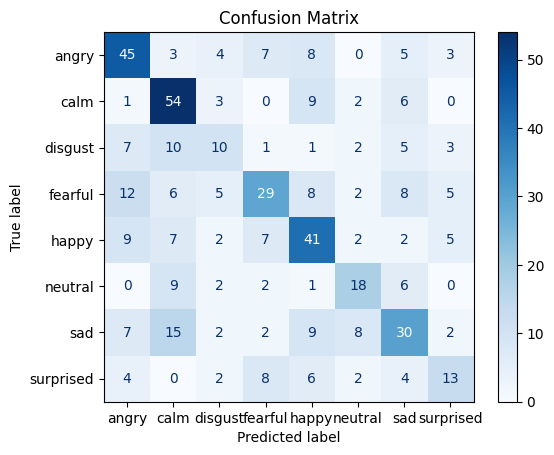

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Predict labels
y_pred_probs = model.predict(X_test_crnn)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=encoder.classes_)

plt.figure(figsize=(10, 8))
disp.plot(cmap="Blues", values_format='d')
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [25]:
# Assuming 'history' is the output from model.fit()
def plot_training_curves(history):
    plt.figure(figsize=(12, 5))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


In [26]:
plot_training_curves(history)


NameError: name 'history' is not defined

In [27]:
import numpy as np
unique_classes, counts = np.unique(y_train, return_counts=True)
print("Encoded Classes:", unique_classes)
print("Class counts:", dict(zip(unique_classes, counts)))

print("X_train shape:", X_train.shape)
print("X_train_crnn shape:", X_train_crnn.shape)
print("y_train shape:", y_train.shape)


Encoded Classes: [0 1 2 3 4 5 6 7]
Class counts: {np.int64(0): np.int64(301), np.int64(1): np.int64(301), np.int64(2): np.int64(153), np.int64(3): np.int64(301), np.int64(4): np.int64(301), np.int64(5): np.int64(150), np.int64(6): np.int64(301), np.int64(7): np.int64(153)}
X_train shape: (1961, 264, 173)
X_train_crnn shape: (1961, 173, 264)
y_train shape: (1961,)


In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dropout, Bidirectional, LSTM, Dense, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint


def build_crnn_refined(input_shape, num_classes):
    model = Sequential()

    # Conv Layer 1
    model.add(Conv1D(64, kernel_size=5, padding='same', activation='relu',
                     kernel_regularizer=l2(0.001), input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Conv Layer 2
    model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    # Conv Layer 3
    model.add(Conv1D(256, kernel_size=3, padding='same', activation='relu', kernel_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # BiLSTM layers
    model.add(Bidirectional(LSTM(128, return_sequences=True)))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dropout(0.4))

    # Dense + Output
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    # Compile
    model.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )
    return model




In [29]:
from sklearn.utils import class_weight
# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('best_crnn_model.h5', save_best_only=True, monitor='val_loss', verbose=1)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1, min_lr=1e-6)

# Train
model = build_crnn_refined(input_shape=X_train_crnn.shape[1:], num_classes=len(encoder.classes_))

# Compute class weights
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary
class_weights_dict = dict(enumerate(class_weights))

# Modify class weights to boost low-performing classes (fearful, sad)
class_weights_dict[3] *= 1.3  # fearful
class_weights_dict[6] *= 1.5  # sad
class_weights_dict[4] *= 1.2  # happy


C:\Users\viren\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [30]:
history = model.fit(
    X_train_crnn,
    y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_crnn, y_test),
    callbacks=[early_stop, checkpoint, lr_scheduler],
    class_weight=class_weights_dict,
    verbose=2
)


Epoch 1/100

Epoch 1: val_loss improved from inf to 2.32764, saving model to best_crnn_model.h5


62/62 - 12s - 191ms/step - accuracy: 0.1652 - loss: 2.6557 - val_accuracy: 0.2118 - val_loss: 2.3276 - learning_rate: 5.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 2.32764 to 2.13819, saving model to best_crnn_model.h5


62/62 - 4s - 62ms/step - accuracy: 0.2376 - loss: 2.5070 - val_accuracy: 0.3157 - val_loss: 2.1382 - learning_rate: 5.0000e-04
Epoch 3/100

Epoch 3: val_loss improved from 2.13819 to 1.98003, saving model to best_crnn_model.h5


62/62 - 4s - 61ms/step - accuracy: 0.2845 - loss: 2.3786 - val_accuracy: 0.3910 - val_loss: 1.9800 - learning_rate: 5.0000e-04
Epoch 4/100

Epoch 4: val_loss improved from 1.98003 to 1.94040, saving model to best_crnn_model.h5


62/62 - 4s - 57ms/step - accuracy: 0.3570 - loss: 2.2046 - val_accuracy: 0.3890 - val_loss: 1.9404 - learning_rate: 5.0000e-04
Epoch 5/100

Epoch 5: val_loss improved from 1.94040 to 1.85710, saving model to best_crnn_model.h5


62/62 - 4s - 57ms/step - accuracy: 0.3870 - loss: 2.1101 - val_accuracy: 0.4257 - val_loss: 1.8571 - learning_rate: 5.0000e-04
Epoch 6/100

Epoch 6: val_loss improved from 1.85710 to 1.73623, saving model to best_crnn_model.h5


62/62 - 4s - 60ms/step - accuracy: 0.4437 - loss: 1.9822 - val_accuracy: 0.4949 - val_loss: 1.7362 - learning_rate: 5.0000e-04
Epoch 7/100

Epoch 7: val_loss did not improve from 1.73623
62/62 - 3s - 53ms/step - accuracy: 0.4834 - loss: 1.8817 - val_accuracy: 0.4562 - val_loss: 1.8342 - learning_rate: 5.0000e-04
Epoch 8/100

Epoch 8: val_loss did not improve from 1.73623
62/62 - 3s - 54ms/step - accuracy: 0.5207 - loss: 1.7595 - val_accuracy: 0.4766 - val_loss: 1.7768 - learning_rate: 5.0000e-04
Epoch 9/100

Epoch 9: val_loss improved from 1.73623 to 1.70357, saving model to best_crnn_model.h5


62/62 - 3s - 54ms/step - accuracy: 0.5385 - loss: 1.6967 - val_accuracy: 0.5071 - val_loss: 1.7036 - learning_rate: 5.0000e-04
Epoch 10/100

Epoch 10: val_loss did not improve from 1.70357
62/62 - 4s - 58ms/step - accuracy: 0.5625 - loss: 1.6398 - val_accuracy: 0.5132 - val_loss: 1.7535 - learning_rate: 5.0000e-04
Epoch 11/100

Epoch 11: val_loss improved from 1.70357 to 1.68623, saving model to best_crnn_model.h5


62/62 - 3s - 55ms/step - accuracy: 0.6033 - loss: 1.5280 - val_accuracy: 0.5153 - val_loss: 1.6862 - learning_rate: 5.0000e-04
Epoch 12/100

Epoch 12: val_loss did not improve from 1.68623
62/62 - 4s - 57ms/step - accuracy: 0.6272 - loss: 1.4486 - val_accuracy: 0.5193 - val_loss: 1.7652 - learning_rate: 5.0000e-04
Epoch 13/100

Epoch 13: val_loss did not improve from 1.68623
62/62 - 3s - 56ms/step - accuracy: 0.6578 - loss: 1.3726 - val_accuracy: 0.5377 - val_loss: 1.7335 - learning_rate: 5.0000e-04
Epoch 14/100

Epoch 14: val_loss did not improve from 1.68623

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
62/62 - 4s - 57ms/step - accuracy: 0.6741 - loss: 1.2995 - val_accuracy: 0.5438 - val_loss: 1.6988 - learning_rate: 5.0000e-04
Epoch 15/100

Epoch 15: val_loss did not improve from 1.68623
62/62 - 4s - 58ms/step - accuracy: 0.7384 - loss: 1.1680 - val_accuracy: 0.5397 - val_loss: 1.7569 - learning_rate: 2.5000e-04
Epoch 16/100

Epoch 16: val_loss improv

62/62 - 4s - 63ms/step - accuracy: 0.7603 - loss: 1.0771 - val_accuracy: 0.5458 - val_loss: 1.6631 - learning_rate: 2.5000e-04
Epoch 17/100

Epoch 17: val_loss improved from 1.66313 to 1.62363, saving model to best_crnn_model.h5


62/62 - 5s - 78ms/step - accuracy: 0.7710 - loss: 1.0377 - val_accuracy: 0.5601 - val_loss: 1.6236 - learning_rate: 2.5000e-04
Epoch 18/100

Epoch 18: val_loss did not improve from 1.62363
62/62 - 3s - 54ms/step - accuracy: 0.7843 - loss: 0.9780 - val_accuracy: 0.5804 - val_loss: 1.6386 - learning_rate: 2.5000e-04
Epoch 19/100

Epoch 19: val_loss did not improve from 1.62363
62/62 - 4s - 57ms/step - accuracy: 0.7960 - loss: 0.9619 - val_accuracy: 0.5642 - val_loss: 1.7320 - learning_rate: 2.5000e-04
Epoch 20/100

Epoch 20: val_loss did not improve from 1.62363

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
62/62 - 4s - 62ms/step - accuracy: 0.8251 - loss: 0.8818 - val_accuracy: 0.5967 - val_loss: 1.7285 - learning_rate: 2.5000e-04
Epoch 21/100

Epoch 21: val_loss did not improve from 1.62363
62/62 - 4s - 58ms/step - accuracy: 0.8210 - loss: 0.8717 - val_accuracy: 0.5886 - val_loss: 1.6870 - learning_rate: 1.2500e-04
Epoch 22/100

Epoch 22: val_loss did no

16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step
✅ Accuracy: 56.01%
✅ F1 Score: 55.71%
✅ Classification Report:
              precision    recall  f1-score   support

       angry       0.75      0.69      0.72        75
        calm       0.49      0.60      0.54        75
     disgust       0.58      0.54      0.56        39
     fearful       0.67      0.47      0.55        75
       happy       0.59      0.55      0.57        75
     neutral       0.41      0.79      0.54        38
         sad       0.60      0.32      0.42        75
   surprised       0.46      0.69      0.55        39

    accuracy                           0.56       491
   macro avg       0.57      0.58      0.56       491
weighted avg       0.59      0.56      0.56       491



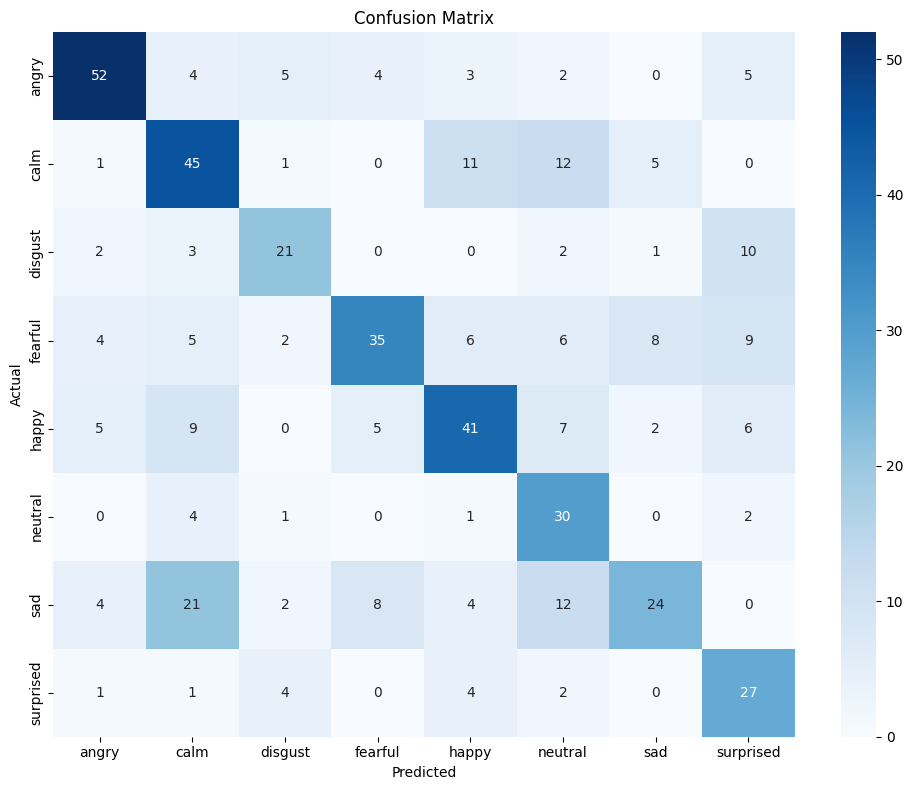

In [31]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Get predictions
y_pred_probs = model.predict(X_test_crnn)
y_pred = np.argmax(y_pred_probs, axis=1)

# Step 2: Accuracy & F1 score
overall_accuracy = accuracy_score(y_test, y_pred)
overall_f1 = f1_score(y_test, y_pred, average='weighted')

print(f"✅ Accuracy: {overall_accuracy * 100:.2f}%")
print(f"✅ F1 Score: {overall_f1 * 100:.2f}%")

# Step 3: Classification Report
print("✅ Classification Report:")
target_names = encoder.classes_  # Use label encoder to decode class names
print(classification_report(y_test, y_pred, target_names=target_names))

# Step 4: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()


In [32]:
# ✅ Number of output classes
num_labels = len(np.unique(y_train))  # typically 8 for 8 emotions


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Activation, Flatten
from tensorflow.keras.optimizers import Adam

# Input shape: (time_steps=173, features=278)
model = Sequential()
model.add(Input(shape=(173, 264)))
  # (time_steps, features)


# 1. Convolutional Block
model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu', input_shape=(173, 278)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# 2. Additional Conv Layer
model.add(Conv1D(128, kernel_size=5, padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.3))

# 3. Bidirectional LSTM
model.add(Bidirectional(LSTM(128, return_sequences=False)))
model.add(Dropout(0.5))

# 4. Fully Connected Dense Layer
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))

# 5. Output Layer
model.add(Dense(num_labels, activation='softmax'))

# Compile
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()


C:\Users\viren\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)                    │ (None, 173, 128)            │         169,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 173, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 86, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 86, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 86, 128)             │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 86, 128)             │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 43, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 256)                 │         263,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │           1,032 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 549,256 (2.10 MB)

 Trainable params: 548,744 (2.09 MB)

 Non-trainable params: 512 (2.00 KB)

In [34]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.5, verbose=1)

history = model.fit(
    X_train_crnn, y_train,
    validation_data=(X_test_crnn, y_test),
    epochs=100,
    batch_size=32,
    callbacks=[early_stop, lr_reduce],
    verbose=1
)


Epoch 1/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - accuracy: 0.1976 - loss: 2.0487 - val_accuracy: 0.2464 - val_loss: 1.8635 - learning_rate: 0.0010
Epoch 2/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.3315 - loss: 1.7547 - val_accuracy: 0.3809 - val_loss: 1.6154 - learning_rate: 0.0010
Epoch 3/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4088 - loss: 1.5360 - val_accuracy: 0.4562 - val_loss: 1.4625 - learning_rate: 0.0010
Epoch 4/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.4829 - loss: 1.3793 - val_accuracy: 0.4745 - val_loss: 1.3623 - learning_rate: 0.0010
Epoch 5/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5488 - loss: 1.2020 - val_accuracy: 0.5071 - val_loss: 1.3383 - learning_rate: 0.0010
Epoch 6/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.5940 - loss: 1.0845 - val_accuracy: 0.5601 - val_loss: 1.1731 - learning_rate: 0.0010
Epoch 7/100
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 45ms/step - accuracy: 0.6191 - loss: 1.0307 - 

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
✅ Accuracy: 56.01%
✅ F1 Score: 55.55%
✅ Classification Report:
              precision    recall  f1-score   support

       angry       0.76      0.69      0.73        75
        calm       0.55      0.68      0.61        75
     disgust       0.45      0.62      0.52        39
     fearful       0.50      0.51      0.50        75
       happy       0.60      0.60      0.60        75
     neutral       0.49      0.58      0.53        38
         sad       0.48      0.29      0.36        75
   surprised       0.60      0.54      0.57        39

    accuracy                           0.56       491
   macro avg       0.55      0.56      0.55       491
weighted avg       0.56      0.56      0.56       491



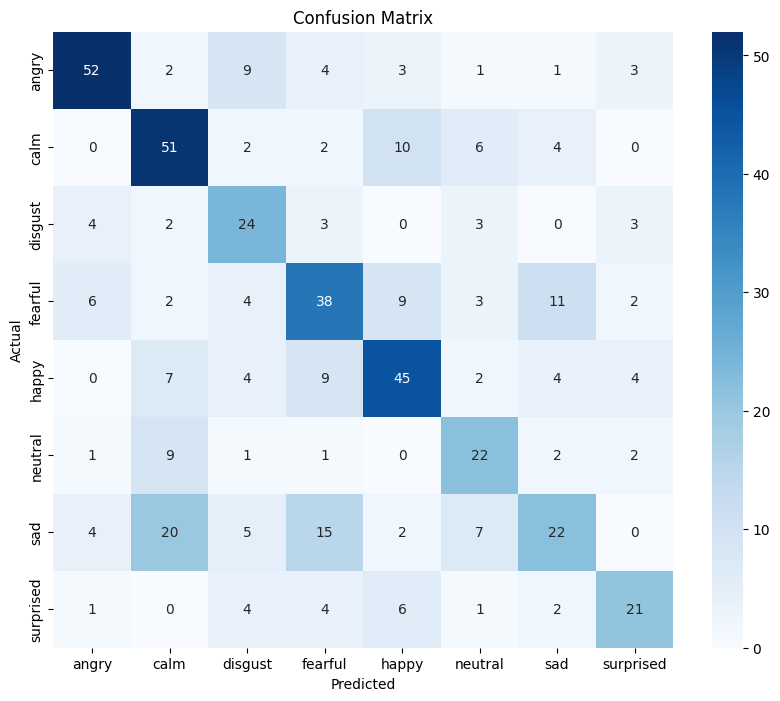

In [35]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict
y_pred = model.predict(X_test_crnn)
y_pred_labels = np.argmax(y_pred, axis=1)

# Metrics
print(f"✅ Accuracy: {accuracy_score(y_test, y_pred_labels) * 100:.2f}%")
print(f"✅ F1 Score: {f1_score(y_test, y_pred_labels, average='weighted') * 100:.2f}%")
print("✅ Classification Report:")
print(classification_report(y_test, y_pred_labels, target_names=encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
